# Exercise 14

## Predict rating using LSTM

Integrates
* Fernando Perez Moreno 200222809
* Juan Camilo Florez Caro 201620135
* Jhon Alexander Florez 201920529
* Angie Paola Chacon 201012536



In [ ]:
import pandas as pd

In [ ]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTraining = dataTraining.reset_index(drop=True)

In [ ]:
plots = dataTraining['plot']
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [ ]:
plots

0       most is the story of a single father who takes...
1       a serial killer decides to teach the secrets o...
2       in sweden ,  a female blackmailer with a disfi...
3       in a friday afternoon in new york ,  the presi...
4       in los angeles ,  the editor of a publishing h...
                              ...                        
7890    " our marriage ,  their wedding .  "  it ' s l...
7891    the wandering barbarian ,  conan ,  alongside ...
7892    like a tale spun by scheherazade ,  kismet fol...
7893    mrs .  brisby ,  a widowed mouse ,  lives in a...
7894    tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [ ]:
y

0       1
1       0
2       1
3       1
4       1
       ..
7890    0
7891    0
7892    0
7893    1
7894    1
Name: rating, Length: 7895, dtype: int64

# Exercise 14.1

- Remove stopwords 
- Lowercase
- split the text in words
- pad_sequences



In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk  import word_tokenize
import string

nltk.download('stopwords')
nltk.download('punkt')
english_stopwords = stopwords.words('english')
punctuation = string.punctuation

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
! pip install livelossplot
from livelossplot import PlotLossesKeras
from keras.layers import SpatialDropout1D
from keras import backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
X = plots.to_list()
# Enviamos todo a minusculas
X = [x.lower() for x in X]
print('# de Plots: ',len(X))

#Join une todoas las listas y split divide según palabras
voc = ''.join(X).split() 
print('Largo con duplicados: ',len(voc))

# Se eliminan Duplicados
voc = set(voc) 
print('Largo sin duplicados: ',len(voc))

# Removemos stopwords
voc = [x for x in voc if x not in english_stopwords]
print('Largo sin stopwords: ',len(voc))

# Removemos puntuacion
voc = [x for x in voc if x not in punctuation]
print('Largo sin puntuación: ',len(voc))

#Codificamos el vocabulario
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}
print('Largo del vocabulario: ',len(vocabulary))



# de Plots:  7895
Largo con duplicados:  1135072
Largo sin duplicados:  40991
Largo sin stopwords:  40841
Largo sin puntuación:  40824
Largo del vocabulario:  40824


In [ ]:
# Identificamos el ancho máximo del pad
maxlen =[]
for i in range(0,len(plots)):
  maxlen.append(len(plots.to_list()[i].split()))
pd.DataFrame(maxlen).describe(percentiles = [0.90,0.95,0.99])

,0
count,7895.000000
mean,144.770868
std,95.816408
min,1.000000
50%,127.000000
90%,274.600000
95%,328.000000
99%,438.060000
max,1863.000000


In [ ]:
max_plot_len =438

X_ = [x.split()[:max_plot_len] for x in X] # Se incluye un split ya que la división es según las palabras
# Convertimos las palabras en un padsequences
X_ = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X_]
X_pad = sequence.pad_sequences(X_, maxlen=max_plot_len)

### Revisamos el ejercicio con un plot puntual

In [ ]:

p = 5
prueba = X[p].split()
#Cortamos el plot de acuerdo al máximo del dataframe deseado
prueba = [x[:max_plot_len] for x in prueba]
# Enviamos todo a minusculas
prueba = [x.lower() for x in prueba]
# Removemos stopwords ya que quedan como 0
prueba = [x for x in prueba if x not in english_stopwords]
# Removemos puntuacion ya que quedan como 0
prueba = [x for x in prueba if x not in punctuation]
print('Largo de la prueba: ',len(prueba))

#Codificamos con el vocabulary
prueba_cod = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in prueba]
print('Largo de la prueba codificada: ',len(prueba_cod))

#Construimos el pad
prueba_pad = sequence.pad_sequences(prueba_cod, maxlen=max_plot_len)
print('Largo de la prueba en versión pad: ',len(prueba_pad))

#Imprimimos la prueba en el pad anteriormente construido para verificar
print('Largo del la prueba en X_pad Definitivo: ',len([i for i in X_pad[p] if i != 0]))

Largo de la prueba:  29
Largo de la prueba codificada:  29
Largo de la prueba en versión pad:  29
Largo del la prueba en X_pad Definitivo:  29


In [ ]:
X_pad

array([[    0,     0,     0, ..., 30652, 37161, 10790],
       [    0,     0,     0, ..., 19038, 15623, 35012],
       [    0,     0,     0, ..., 37790, 22718, 23589],
       ...,
       [    0,     0,     0, ..., 32531, 36788,  2296],
       [    0,     0,     0, ..., 20947,  4343, 38765],
       [    0,     0,     0, ..., 17676,  8856, 14465]], dtype=int32)

In [ ]:
y

0       1
1       0
2       1
3       1
4       1
       ..
7890    0
7891    0
7892    0
7893    1
7894    1
Name: rating, Length: 7895, dtype: int64

# Exercise 14.2

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.1, random_state=42)

In [ ]:
K.clear_session()
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 50, input_length=max_plot_len))

model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))

model.add(Dropout(0.8)) #Controlamos el overfitting

model.add(Dense(50, activation='relu')) 

model.add(Dropout(0.8)) #Controlamos el overfitting

model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()   

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 438, 50)           2041250   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,064,051
Trainable params: 2,064,051
Non-trainable params: 0
____________________________________________

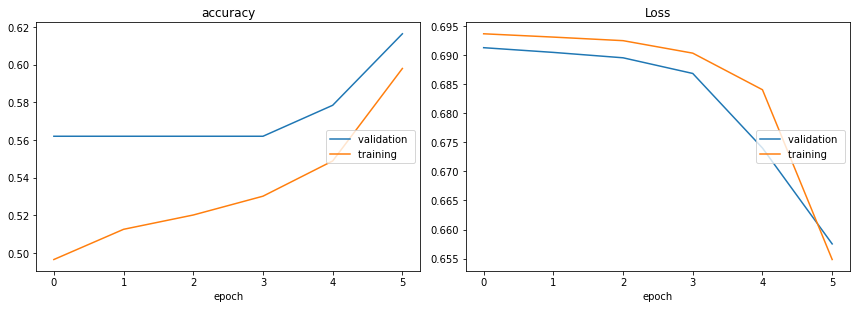

accuracy
	validation       	 (min:    0.562, max:    0.616, cur:    0.616)
	training         	 (min:    0.497, max:    0.598, cur:    0.598)
Loss
	validation       	 (min:    0.658, max:    0.691, cur:    0.658)
	training         	 (min:    0.655, max:    0.694, cur:    0.655)


In [ ]:
model.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size=500, epochs=6, verbose=1,
          callbacks=[PlotLossesKeras()])

In [ ]:
y_pred = model.predict_classes(X_test)[:,0]

print((y_pred == y_test).mean())#Generamos el accuracy del modelo

0.6164556962025316
